# NRP Tutorial: Baseball experiment

Welcome to this turorial. By following this notebook step by step, you will have fun and learn how to work with the Neurorobotics Platform.

# Offline Optimization with Virtual Coach

In [13]:
# log into the virtual coach, update with your credentials
try:
    from hbp_nrp_virtual_coach.virtual_coach import VirtualCoach
    vc = VirtualCoach(environment='local')
except ImportError as e:
    print(e)
    print("You have to start this notebook with the command:\
          cle-virtual-coach jupyter notebook")
    raise e

# disable global logging from the virtual coach
import logging
logging.disable(logging.INFO)

In [91]:
import tempfile
import os
import csv
import time

class Trial(object):
    def __init__(self, sim_name, csv_files):
        self._sim = vc.launch_experiment(sim_name)
        self._sim.register_status_callback(self._on_status)
        self.dir = tempfile.mkdtemp()
        self._stopped = False
        self._csv_files = csv_files
    
    def _save_csv_files(self):
        #csv_file_names = self._sim.print_csv_file_names()
        for csv_file_name in self._csv_files:
            with open(os.path.join(self.dir, csv_file_name), 'wb') as f:
                cf = csv.writer(f)
                cf.writerows(self._sim.get_csv_data(csv_file_name))

    
    def run(self):
        self._sim.start()

        # wait until the simulation terminates cleanly, blocking call
        while not self._stopped:
            time.sleep(1.0)
   
    def stop(self):
        self._sim.stop()
        
    def _on_status(self, msg):
            # simulation has been terminated
        if msg['state'] == 'stopped':
            self._stopped = True
            return
        
        #print msg['simulationTime']
        # simulation timeline events, only disable stimulus and stop when non interactive
        if msg['simulationTime'] >= 5.0:
            self._sim.pause()

            # write all position data to disk if a path was given
            try:
                self._save_csv_files()
            finally:
                self._sim.stop()
    
    

In [92]:
csv_files = ['ball_states.csv', 'joint_states.csv']
trial = Trial('ExDTutorialBaseball', csv_files)
trial.run()

ERROR: [2017-07-18 10:56:02,442 - rospy.internal] Unable to initiate TCP/IP socket to 127.0.0.1:36531 (http://127.0.0.1:36189/): Traceback (most recent call last):
  File "/opt/ros/indigo/lib/python2.7/dist-packages/rospy/impl/tcpros_base.py", line 557, in connect
    self.read_header()
  File "/opt/ros/indigo/lib/python2.7/dist-packages/rospy/impl/tcpros_base.py", line 619, in read_header
    self._validate_header(read_ros_handshake_header(sock, self.read_buff, self.protocol.buff_size))
  File "/opt/ros/indigo/lib/python2.7/dist-packages/rospy/impl/tcpros_base.py", line 580, in _validate_header
    raise TransportInitError("remote error reported: %s"%header['error'])
TransportInitError: remote error reported: Internal error processing topic [/ros_cle_simulation/cle_error]

ERROR: [2017-07-18 10:56:02,442 - rospy.internal] Unable to initiate TCP/IP socket to 127.0.0.1:36531 (http://127.0.0.1:36189/): Traceback (most recent call last):
  File "/opt/ros/indigo/lib/python2.7/dist-packages

[ERROR] [WallTime: 1500393364.505476] [5.221000] bad callback: <bound method Simulation.__on_status of <hbp_nrp_virtual_coach.simulation.Simulation object at 0x7f2a3dbc0390>>
Traceback (most recent call last):
  File "/opt/ros/indigo/lib/python2.7/dist-packages/rospy/topics.py", line 720, in _invoke_callback
    cb(msg)
  File "/home/perser/HBP/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 264, in __on_status
    callback(status)
  File "<ipython-input-91-81c8ca880c89>", line 41, in _on_status
    self._sim.pause()
  File "/home/perser/HBP/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 167, in pause
    self.__set_state('paused')
  File "/home/perser/HBP/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 220, in __set_state
    res, _ = self.__oidc_client.request(url, method='PUT', body=json.dumps({'state': state}))
  File "/home/perser/.opt/platform_venv/

In [93]:
import pandas
import numpy as np

ball_csv = pandas.read_csv(os.path.join(trial.dir, csv_files[0]))
joint_csv = pandas.read_csv(os.path.join(trial.dir, csv_files[1]))

In [118]:
dist = ball_csv.diff().fillna(0.)
dist['Dist'] = np.sqrt(dist.px**2 + dist.py**2 + dist.pz**2)
dist['Speed'] = dist.Dist / (dist.Time)
dist['Time'] = ball_csv['Time']
ball_speed_table = dist[['Time', 'Speed']].fillna(0.)

x_table = ball_csv[['Time', 'px']]


shoulder_speed_table = joint_csv[joint_csv['Name'] == 'r_shoulder_yaw'][['Time', 'Position']]

table1 = shoulder_speed_table.set_index(['Time'])
table2 = ball_speed_table.set_index(['Time'])

total_table = pandas.merge(ball_speed_table, shoulder_speed_table).set_index(['Time'])
print table1, table2

table2 = table2[table2['Speed'] < 40.]

      Position
Time          
0.00  0.000219
0.02  0.000219
0.04  0.000247
0.06  0.001379
0.08  0.001108
0.10  0.000971
0.12 -0.002790
0.14 -0.002790
0.16 -0.005421
0.18 -0.005825
0.20 -0.005825
0.22 -0.005344
0.24 -0.004654
0.26 -0.003700
0.28 -0.003700
0.30 -0.002483
0.32 -0.000978
0.34 -0.000978
0.36 -0.000293
0.38 -0.007102
0.40 -0.009427
0.42 -0.009427
0.44 -0.008343
0.46 -0.005570
0.48 -0.005570
0.50 -0.002650
0.52 -0.001019
0.54 -0.000004
0.56  0.000644
0.58  0.000644
...        ...
5.04  0.483679
5.06  0.479491
5.08  0.527852
5.10  0.578146
5.12  0.554600
5.14  0.510344
5.16  0.483466
5.18  0.428553
5.20  0.414577
5.22  0.382255
5.24  0.328966
5.26  0.278005
5.28  0.241374
5.30  0.207925
5.32  0.174687
5.34  0.127485
5.36  0.111819
5.38  0.097704
5.40  0.075417
5.42  0.111817
5.44  0.230374
5.46  0.230374
5.48  0.222262
5.50  0.405741
5.52  0.500554
5.54  0.581543
5.56  0.521497
5.58  0.444679
5.60  0.475269
5.62  0.475269

[282 rows x 1 columns]           Speed
Time           

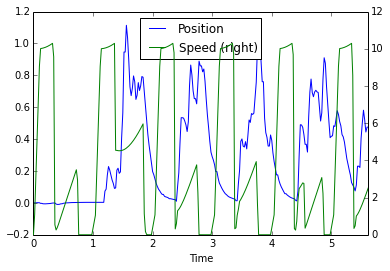

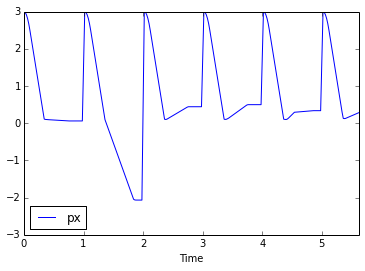

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.figure()
ax1 = table1.plot()
#ax2 = ax1.twinx()
table2.plot(ax=ax1, secondary_y=True)
x_table.set_index(['Time']).plot()
plt.show()
